<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/SCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 37.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
import time
from sklearn.model_selection import ParameterGrid

# Start Timer
start_time = time.time()

# Load Data
print("Loading data...")
data = pd.read_csv('basePM25nearest_grid.csv')
model_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')

# Extract Model Data
model_lons = model_data['lon'].values
model_lats = model_data['lat'].values
model_values = model_data['SURF_ug_PM25_rh50'].values[0].astype(np.float32)  # Use float32 to reduce memory usage

# Extract Station Data
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()
stations_data['nearest_SURF_ug_PM25_rh50'] = data['nearest_SURF_ug_PM25_rh50']

# Compute Bias
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# Define Weight Functions
def gaussian_weight(distance, radius):
    return np.exp(- (distance**2) / (2 * radius**2))

def inverse_distance_weight(distance, radius):
    return 1 / (1 + distance / radius)

def linear_weight(distance, radius):
    return np.maximum(0, 1 - distance / radius)

# Successive Correction Method (SCM) Implementation
def successive_correction(model_lons, model_lats, model_values, stations_data, iterations=5, radius=1.0, weight_function='gaussian'):
    lon_grid, lat_grid = np.meshgrid(model_lons, model_lats)
    bias_field = np.zeros_like(model_values, dtype=np.float32)

    weight_func = {
        'gaussian': gaussian_weight,
        'inverse_distance': inverse_distance_weight,
        'linear': linear_weight
    }[weight_function]

    for iteration in tqdm(range(iterations), desc="SCM Progress"):
        for _, row in stations_data.iterrows():
            obs_lon, obs_lat, obs_bias = row['lon'], row['lat'], row['bias']

            # Compute distance between grid points and observation
            distances = np.sqrt((lon_grid - obs_lon)**2 + (lat_grid - obs_lat)**2)

            # Compute weights
            weights = weight_func(distances, radius)

            # Apply correction
            bias_field += weights * obs_bias

        # Normalize correction to prevent over-adjustment
        bias_field /= (bias_field.max() if bias_field.max() != 0 else 1)

    return bias_field

# Hyperparameter Search Grid
param_grid = {
    "radius": [0.2, 0.5, 1.0, 1.5, 2.0],
    "iterations": [3, 5, 10, 15],
    "weight_function": ["gaussian", "inverse_distance", "linear"],
}

# Hyperparameter Optimization
print("Searching for best hyperparameters...")
best_params = None
best_score = float("inf")

for params in ParameterGrid(param_grid):
    z_bias = successive_correction(
        model_lons, model_lats, model_values, stations_data,
        iterations=params["iterations"], radius=params["radius"], weight_function=params["weight_function"]
    )

    # Evaluate Model Performance (Mean Absolute Error - MAE)
    score = np.nanmean(np.abs(z_bias - stations_data['bias'].mean()))

    if score < best_score:
        best_score = score
        best_params = params

print(f"Best Hyperparameters: {best_params}, Best Score: {best_score}")

# Apply SCM with Best Parameters
print("Applying SCM with best parameters...")
z_bias = successive_correction(
    model_lons, model_lats, model_values, stations_data,
    iterations=best_params["iterations"], radius=best_params["radius"], weight_function=best_params["weight_function"]
)

# Apply Bias Correction
corrected_values = model_values + z_bias
corrected_data = model_data.copy()
corrected_data['SURF_ug_PM25_rh50_corrected'] = (['time', 'lat', 'lon'], corrected_values[np.newaxis, :, :])

# Save Corrected Data
print("Saving corrected NetCDF file...")
corrected_data.to_netcdf('SCM_BC_PERT_PM25_rh50.nc')

# End Timer
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


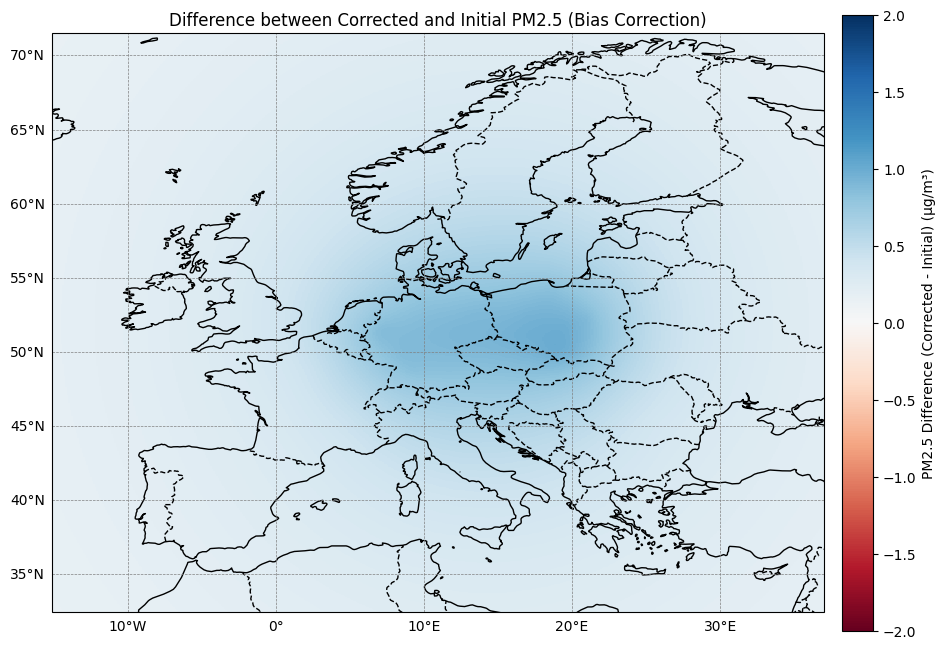

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "SCM_BC_PERT_PM25_rh50.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -2
cbar_max = 2

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()
